In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder,power_transform,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
!pip install scikit-plot
import scikitplot as skplt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
!pip install pyfiglet
import pyfiglet

In [2]:
data=pd.read_csv('/content/Web_Scraped_Flight_Data1.csv')

In [3]:
data

,Unnamed: 0,Unnamed: 0.1,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price
0,0,0,Jet Airways,Banglore,Delhi,18:55,22:00,3h 5m,non-stop,7229
1,1,1,Multiple carriers,Delhi,Cochin,10:20,01:30 22 May,15h 10m,1 stop,7485
2,2,2,IndiGo,Banglore,Delhi,18:55,21:50,2h 55m,non-stop,4823
3,3,3,Air India,Delhi,Cochin,05:55,07:40 07 Mar,25h 45m,2 stops,14641
4,4,4,SpiceJet,Kolkata,Banglore,06:55,09:30,2h 35m,non-stop,3841
...,...,...,...,...,...,...,...,...,...,...
1669,1669,1669,IndiGo,Banglore,Delhi,04:00,06:50,2h 50m,non-stop,4423
1670,1670,1670,Jet Airways,Kolkata,Banglore,08:25,18:15,9h 50m,1 stop,10844
1671,1671,1671,Jet Airways,Delhi,Cochin,19:30,12:35 28 Jun,17h 5m,2 stops,13764
1672,1672,1672,Air India,Delhi,Cochin,23:00,19:15 10 Mar,20h 15m,1 stop,11260


In [4]:
data.describe()

,Unnamed: 0,Unnamed: 0.1,Price
count,1674.000000,1674.000000,1674.000000
mean,836.500000,836.500000,9083.091995
std,483.386491,483.386491,4475.845590
min,0.000000,0.000000,1965.000000
25%,418.250000,418.250000,5403.000000
50%,836.500000,836.500000,8529.000000
75%,1254.750000,1254.750000,12361.500000
max,1673.000000,1673.000000,57209.000000


In [5]:
data.isna().sum()

Unnamed: 0      0
Unnamed: 0.1    0
Airline         0
Source          0
Destination     0
Dep_Time        0
Arrival_Time    0
Duration        0
Total_Stops     0
Price           0
dtype: int64

**There are no missing values**



In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1674 entries, 0 to 1673
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1674 non-null   int64 
 1   Unnamed: 0.1  1674 non-null   int64 
 2   Airline       1674 non-null   object
 3   Source        1674 non-null   object
 4   Destination   1674 non-null   object
 5   Dep_Time      1674 non-null   object
 6   Arrival_Time  1674 non-null   object
 7   Duration      1674 non-null   object
 8   Total_Stops   1674 non-null   object
 9   Price         1674 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 130.9+ KB


**We have only one column that is numeric that is target column**

#Preprocessing
1-Doing feature engineering

2-Filling missing values

3-Droping some columns

Dropping Route it is not important because we just want to predict the price so basically we need Source and destination and also Droping additional info because it is not important for fligh fare prediction and also dropping Date of journey because i have converted that into years,month,day and also dropping duration because if we have Dep_time and Arrival_time we dont need it because it just represent the difference between these two only

In [12]:
def preprocess1(df):
  df['Total_Stops']=df['Total_Stops'].fillna(df['Total_Stops'].mode()[0])
  df=df.drop(['Duration'],axis=1)
  return df

In [13]:
data=preprocess1(data)

In [14]:
data

,Unnamed: 0,Unnamed: 0.1,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Price
0,0,0,Jet Airways,Banglore,Delhi,18:55,22:00,non-stop,7229
1,1,1,Multiple carriers,Delhi,Cochin,10:20,01:30 22 May,1 stop,7485
2,2,2,IndiGo,Banglore,Delhi,18:55,21:50,non-stop,4823
3,3,3,Air India,Delhi,Cochin,05:55,07:40 07 Mar,2 stops,14641
4,4,4,SpiceJet,Kolkata,Banglore,06:55,09:30,non-stop,3841
...,...,...,...,...,...,...,...,...,...
1669,1669,1669,IndiGo,Banglore,Delhi,04:00,06:50,non-stop,4423
1670,1670,1670,Jet Airways,Kolkata,Banglore,08:25,18:15,1 stop,10844
1671,1671,1671,Jet Airways,Delhi,Cochin,19:30,12:35 28 Jun,2 stops,13764
1672,1672,1672,Air India,Delhi,Cochin,23:00,19:15 10 Mar,1 stop,11260


In [15]:
def preprocess2(df):
  df['Dep_hour']=pd.to_datetime(df['Dep_Time']).dt.hour
  df['Dep_minute']=pd.to_datetime(df['Dep_Time']).dt.minute
  df=df.drop(['Dep_Time'],axis=1)
  df['arrival_hour']=pd.to_datetime(df['Arrival_Time']).dt.hour
  df['arrival_minute']=pd.to_datetime(df['Arrival_Time']).dt.minute
  df=df.drop(['Arrival_Time'],axis=1)
  return df

In [16]:
data=preprocess2(data)

In [17]:
data

,Unnamed: 0,Unnamed: 0.1,Airline,Source,Destination,Total_Stops,Price,Dep_hour,Dep_minute,arrival_hour,arrival_minute
0,0,0,Jet Airways,Banglore,Delhi,non-stop,7229,18,55,22,0
1,1,1,Multiple carriers,Delhi,Cochin,1 stop,7485,10,20,1,30
2,2,2,IndiGo,Banglore,Delhi,non-stop,4823,18,55,21,50
3,3,3,Air India,Delhi,Cochin,2 stops,14641,5,55,7,40
4,4,4,SpiceJet,Kolkata,Banglore,non-stop,3841,6,55,9,30
...,...,...,...,...,...,...,...,...,...,...,...
1669,1669,1669,IndiGo,Banglore,Delhi,non-stop,4423,4,0,6,50
1670,1670,1670,Jet Airways,Kolkata,Banglore,1 stop,10844,8,25,18,15
1671,1671,1671,Jet Airways,Delhi,Cochin,2 stops,13764,19,30,12,35
1672,1672,1672,Air India,Delhi,Cochin,1 stop,11260,23,0,19,15


In [18]:
def countplot(x):
  plt.figure(figsize=(12,8))
  sns.countplot(x)
  plt.xticks(rotation=90,fontsize=14)
  plt.yticks(fontsize=14)
  return plt.show()

#Countplot of Airlines

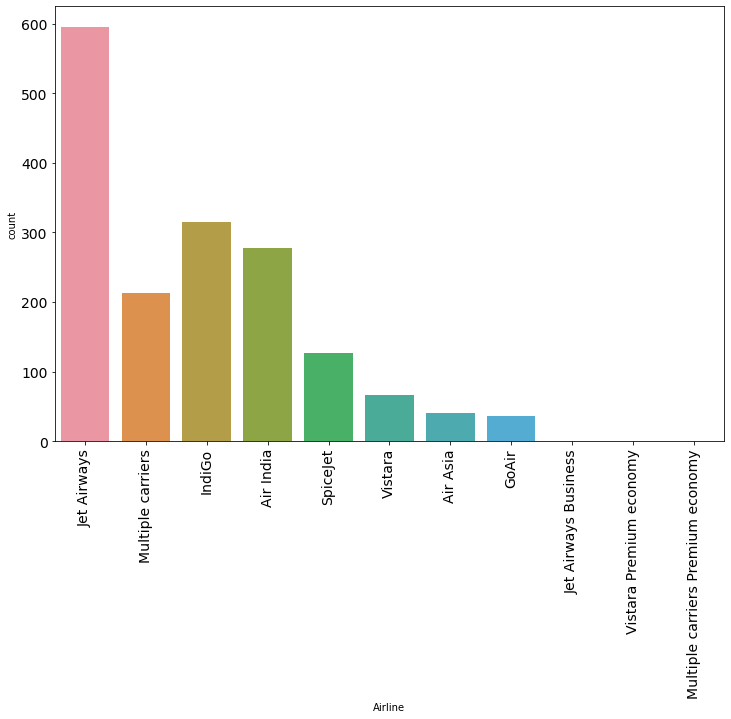

In [19]:
countplot(data['Airline'])

#Obseravtion

1-Mostly people use to travel with Jet Airways

2-After Jet Airways people use to travel with IndiGo

3-ANd GoAir has the least count why i am saying least count because Vistara,Jet Airways,MCPE,Trujet has no count 

#Countplot of Source

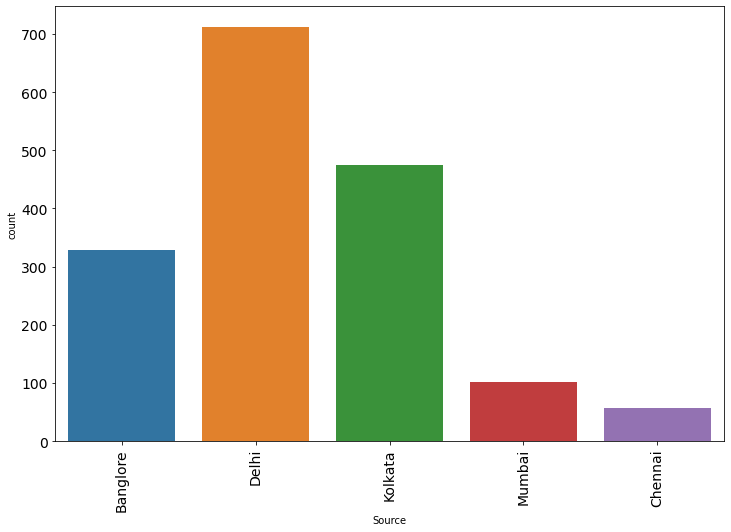

In [20]:
countplot(data['Source'])

#Obseravtion

1-Mostly Source has delhi as high count

2-after delhi kolkata has 2nd high count

3-and at least chennai means very less people source is chennai 

#Countplot of Destination

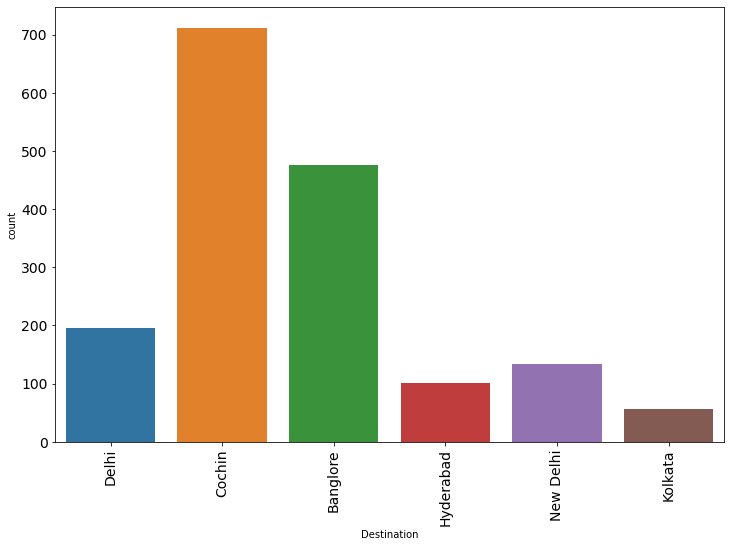

In [21]:
countplot(data['Destination'])

#Obseravtion

1-Mostly people use to go Cochin as per the data what i have

2-after Cochin people use to go to Banglore

3-And very less people use to go to Kolkata

#Countplot of Total_Stops

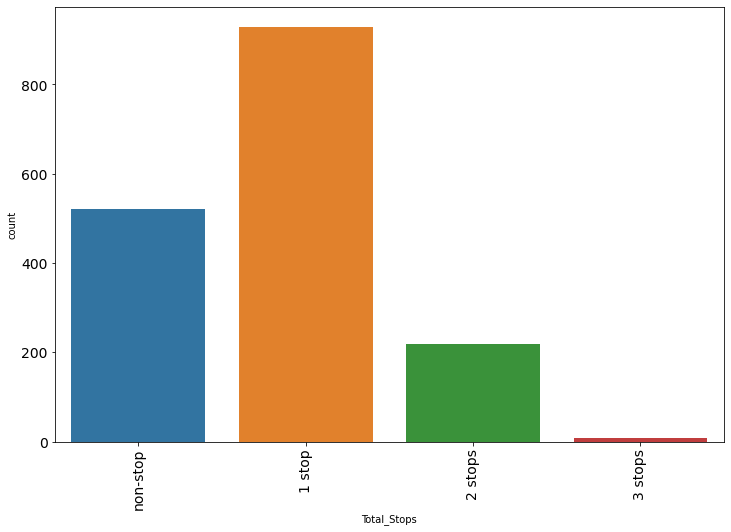

In [22]:
countplot(data['Total_Stops'])

#Obseravtion

1-Mostly people use to take a fligh who has only one stop 

2-after one stop people used to take non-stop flights

3-ANd only approx 1500 people use to take 2 stop flights

4-ANd there are very less people who used to take 3 stops or 4 stops flight

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.]),
 <a list of 8 Text major ticklabel objects>)

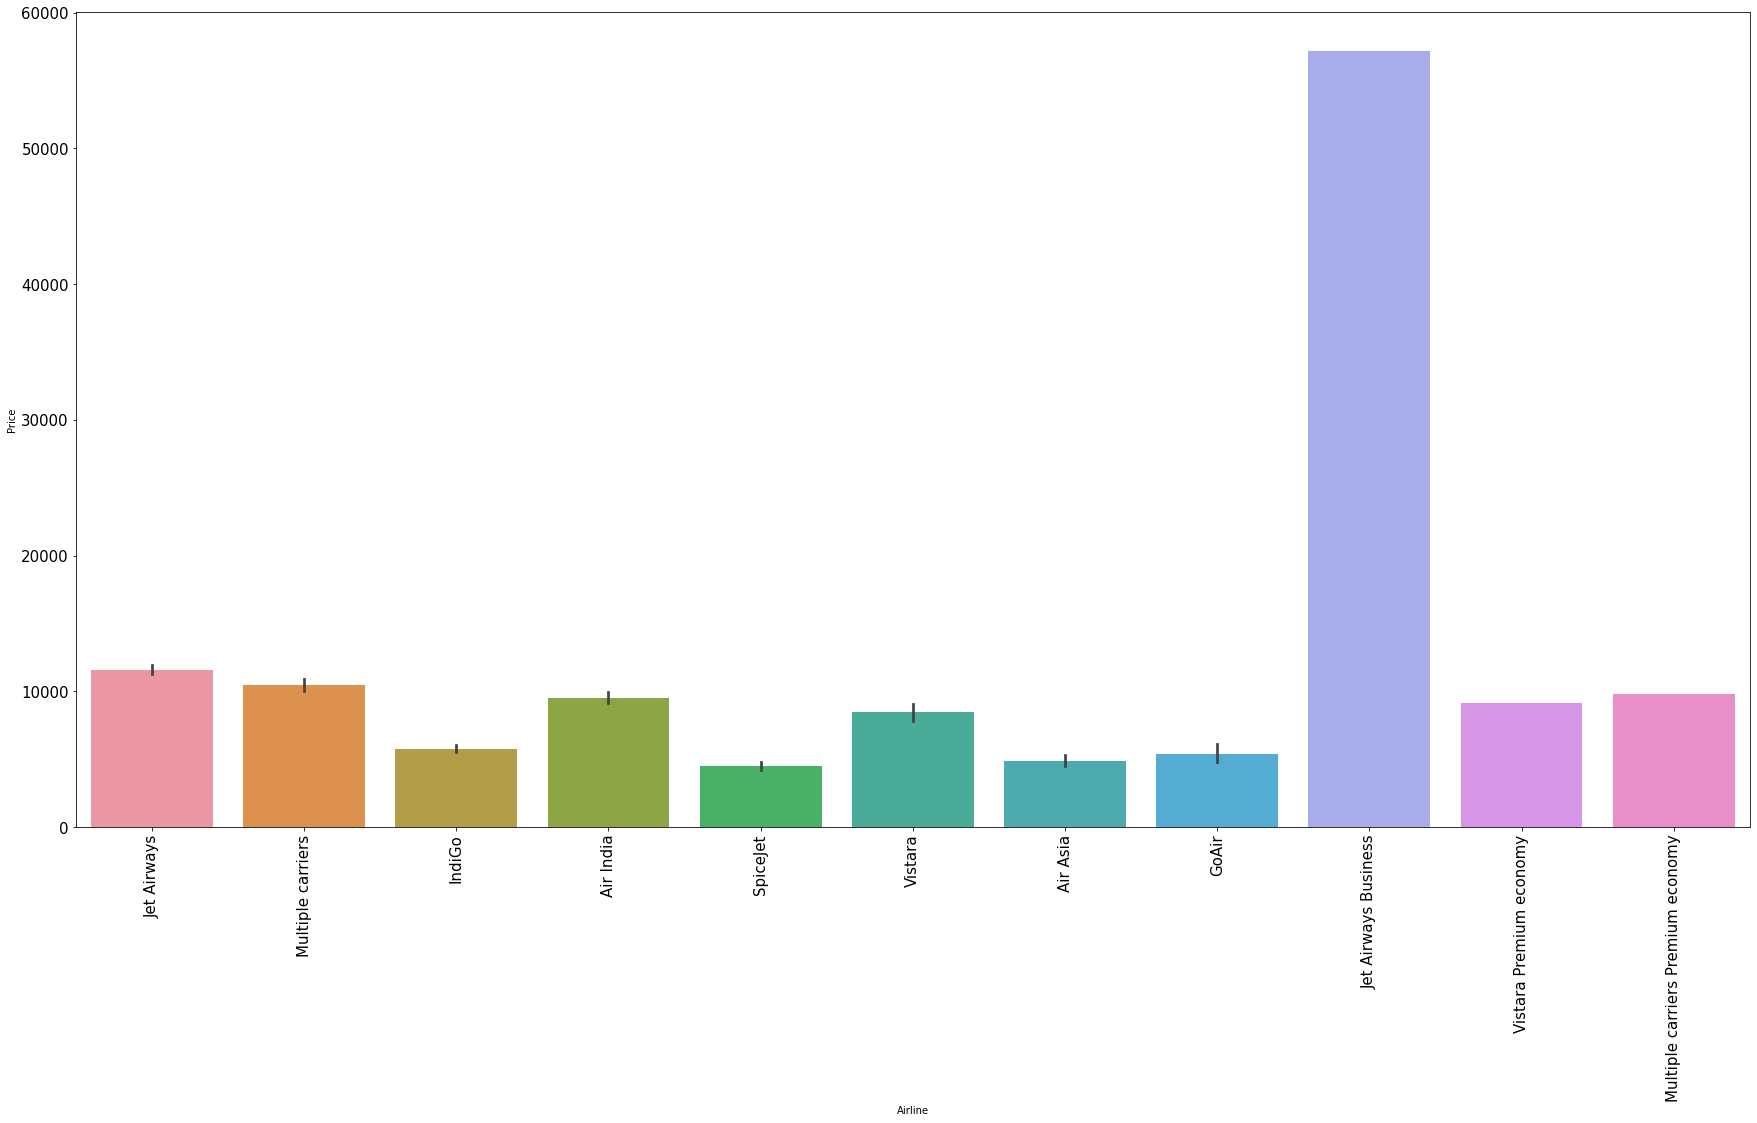

In [25]:
plt.figure(figsize=(30,15))
sns.barplot(x='Airline',y='Price',data=data)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

#Obseravtion

1-From upper graph i can say Jet Airways Business has the highest price 

2-and spicejet,Indigo,GoAIr,Air Asia is cheap for travel

3-Jet Airways ,Mutiple carriers,Air India have medium price nor high neither low price

In [26]:
data

,Unnamed: 0,Unnamed: 0.1,Airline,Source,Destination,Total_Stops,Price,Dep_hour,Dep_minute,arrival_hour,arrival_minute
0,0,0,Jet Airways,Banglore,Delhi,non-stop,7229,18,55,22,0
1,1,1,Multiple carriers,Delhi,Cochin,1 stop,7485,10,20,1,30
2,2,2,IndiGo,Banglore,Delhi,non-stop,4823,18,55,21,50
3,3,3,Air India,Delhi,Cochin,2 stops,14641,5,55,7,40
4,4,4,SpiceJet,Kolkata,Banglore,non-stop,3841,6,55,9,30
...,...,...,...,...,...,...,...,...,...,...,...
1669,1669,1669,IndiGo,Banglore,Delhi,non-stop,4423,4,0,6,50
1670,1670,1670,Jet Airways,Kolkata,Banglore,1 stop,10844,8,25,18,15
1671,1671,1671,Jet Airways,Delhi,Cochin,2 stops,13764,19,30,12,35
1672,1672,1672,Air India,Delhi,Cochin,1 stop,11260,23,0,19,15


#Feature Transformation

In [27]:
oe=OrdinalEncoder()
def ordinal_encoder(df,col):
  df[col]=oe.fit_transform(df[col])
  return df

**USing ordinal encoder because i have features who have values in order**

In [28]:
data=ordinal_encoder(data,['Airline','Source','Destination','Total_Stops'])

#Spliting data into dependent and independent variable

In [29]:
def preprocess3(df):
  df=df.copy()
  X=df.drop(['Price'],axis=1)
  y=df['Price']
  return X,y

In [30]:
X,y=preprocess3(data)

In [36]:
X.drop(['Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,np.log(y),test_size=0.3,random_state=42)

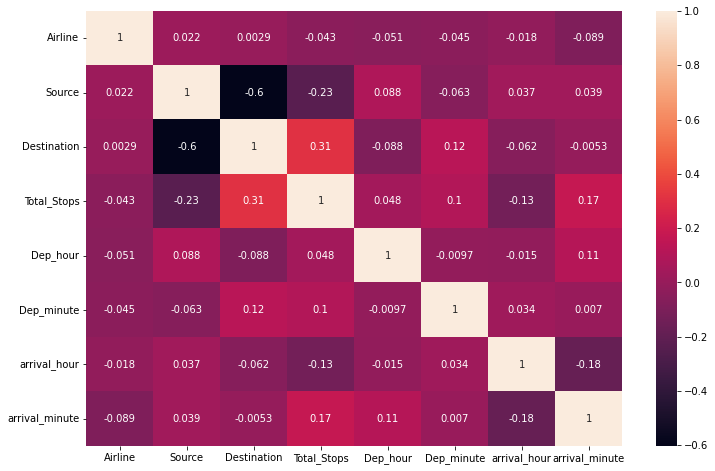

In [38]:
X_corr=X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(X_corr,annot=True)

#Obseravtion

from upper graph i can say most of teh columns are having less correlation because most of every column is categorical and through this correlation we can only find correlation with numerical data

#Checking Outliers

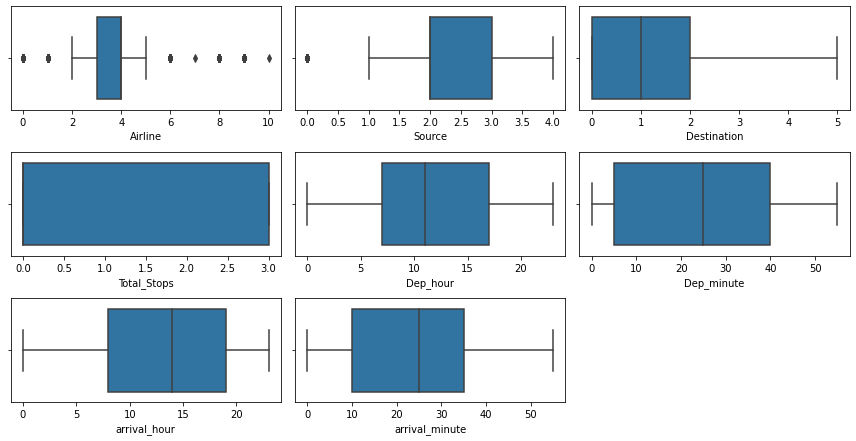

In [39]:
X_val=X.columns.values
plt.figure(figsize=(12,20))
for i in range(len(X_val)):
  plt.subplot(10,3,i+1)
  sns.boxplot(X[X_val[i]])
  plt.tight_layout()

#Obseravtion

there is no outliers becaise every column is categorical we dont have any continuous column in X

#Checking SKewness

In [40]:
X.skew()

Airline           0.511883
Source           -0.480290
Destination       1.311241
Total_Stops       0.643756
Dep_hour          0.194887
Dep_minute        0.183776
arrival_hour     -0.420247
arrival_minute    0.158993
dtype: float64

#Obseravtion
There is no skewness because every column is categorical we dont remove skewness of categorical column 

#NOTE--

I am not using scaling my features because i am not having any continuous feature in X means in independent feature so my every feature is categorical so no need to scale the features

#Training Multiple models

In [41]:
models={
    "XGB Regressor":XGBRegressor(),
    "ExtraTrees Regressor":ExtraTreesRegressor(),
    "RandomForest Regressor":RandomForestRegressor(),
    "Linear Regression":LinearRegression(),
    "DecisionTree Regressor":DecisionTreeRegressor(),
    "Lasso":Lasso(),
    "LIGHT GBM":LGBMRegressor()
}

__  ______ ____    ____                                         
\ \/ / ___| __ )  |  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
 \  / |  _|  _ \  | |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
 /  \ |_| | |_) | |  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
/_/\_\____|____/  |_| \_\___|\__, |_|  \___||___/___/\___/|_|   
                             |___/                              

[07:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MEAN SQUARED ERROR 0.06808026645515229


MEAN ABSOLUTE ERROR 0.19714117663333494
[07:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:46:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:46:56] WARNING: 

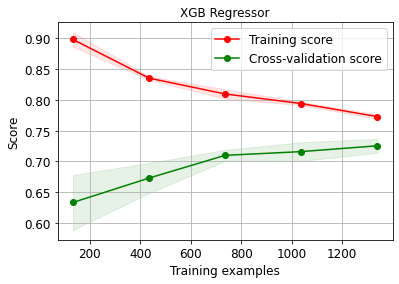

 _____      _            _____                   
| ____|_  _| |_ _ __ __ |_   _| __ ___  ___  ___ 
|  _| \ \/ / __| '__/ _` || || '__/ _ \/ _ \/ __|
| |___ >  <| |_| | | (_| || || | |  __/  __/\__ \
|_____/_/\_\\__|_|  \__,_||_||_|  \___|\___||___/
                                                 
 ____                                         
|  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
| |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
|  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
|_| \_\___|\__, |_|  \___||___/___/\___/|_|   
           |___/                              

MEAN SQUARED ERROR 0.07885886778803769


MEAN ABSOLUTE ERROR 0.18409744420577856


CVS_SCORE 0.692416708629543


R2_SCORE 0.6860737080339332


RMSE 0.28081821128274015


MODEL PERFORMANCE CURVE


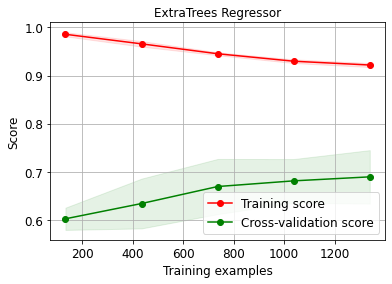

 ____                 _                 _____                   _   
|  _ \ __ _ _ __   __| | ___  _ __ ___ |  ___|__  _ __ ___  ___| |_ 
| |_) / _` | '_ \ / _` |/ _ \| '_ ` _ \| |_ / _ \| '__/ _ \/ __| __|
|  _ < (_| | | | | (_| | (_) | | | | | |  _| (_) | | |  __/\__ \ |_ 
|_| \_\__,_|_| |_|\__,_|\___/|_| |_| |_|_|  \___/|_|  \___||___/\__|
                                                                    
 ____                                         
|  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
| |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
|  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
|_| \_\___|\__, |_|  \___||___/___/\___/|_|   
           |___/                              

MEAN SQUARED ERROR 0.06573693111520763


MEAN ABSOLUTE ERROR 0.1782409177392601


CVS_SCORE 0.7145080405626723


R2_SCORE 0.7383103307329464


RMSE 0.2563921432400136


MODEL PERFORMANCE CURVE


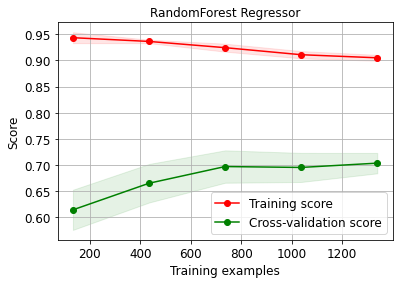

 _     _                       
| |   (_)_ __   ___  __ _ _ __ 
| |   | | '_ \ / _ \/ _` | '__|
| |___| | | | |  __/ (_| | |   
|_____|_|_| |_|\___|\__,_|_|   
                               
 ____                              _             
|  _ \ ___  __ _ _ __ ___  ___ ___(_) ___  _ __  
| |_) / _ \/ _` | '__/ _ \/ __/ __| |/ _ \| '_ \ 
|  _ <  __/ (_| | | |  __/\__ \__ \ | (_) | | | |
|_| \_\___|\__, |_|  \___||___/___/_|\___/|_| |_|
           |___/                                 

MEAN SQUARED ERROR 0.1450343456720914


MEAN ABSOLUTE ERROR 0.31072677462294696


CVS_SCORE 0.4450997009085321


R2_SCORE 0.42263824447818177


RMSE 0.38083375069981834


MODEL PERFORMANCE CURVE


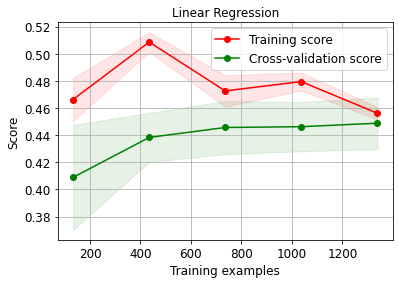

 ____            _     _           _____              
|  _ \  ___  ___(_)___(_) ___  _ _|_   _| __ ___  ___ 
| | | |/ _ \/ __| / __| |/ _ \| '_ \| || '__/ _ \/ _ \
| |_| |  __/ (__| \__ \ | (_) | | | | || | |  __/  __/
|____/ \___|\___|_|___/_|\___/|_| |_|_||_|  \___|\___|
                                                      
 ____                                         
|  _ \ ___  __ _ _ __ ___  ___ ___  ___  _ __ 
| |_) / _ \/ _` | '__/ _ \/ __/ __|/ _ \| '__|
|  _ <  __/ (_| | | |  __/\__ \__ \ (_) | |   
|_| \_\___|\__, |_|  \___||___/___/\___/|_|   
           |___/                              

MEAN SQUARED ERROR 0.09943908935253523


MEAN ABSOLUTE ERROR 0.2068527169331664


CVS_SCORE 0.63754306899584


R2_SCORE 0.6041466803602893


RMSE 0.31533964126404285


MODEL PERFORMANCE CURVE


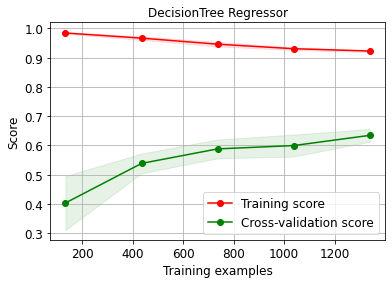

 _                        
| |    __ _ ___ ___  ___  
| |   / _` / __/ __|/ _ \ 
| |__| (_| \__ \__ \ (_) |
|_____\__,_|___/___/\___/ 
                          

MEAN SQUARED ERROR 0.25219223792388173


MEAN ABSOLUTE ERROR 0.42147797609076587


CVS_SCORE -0.006818714251773361


R2_SCORE -0.003942566444984363


RMSE 0.502187452973371


MODEL PERFORMANCE CURVE


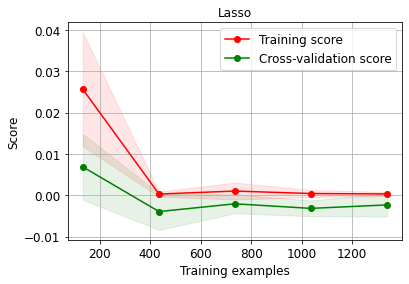

 _     ___ ____ _   _ _____    ____ ____  __  __ 
| |   |_ _/ ___| | | |_   _|  / ___| __ )|  \/  |
| |    | | |  _| |_| | | |   | |  _|  _ \| |\/| |
| |___ | | |_| |  _  | | |   | |_| | |_) | |  | |
|_____|___\____|_| |_| |_|    \____|____/|_|  |_|
                                                 

MEAN SQUARED ERROR 0.06780527033441756


MEAN ABSOLUTE ERROR 0.18596436927896234


CVS_SCORE 0.7212962482958633


R2_SCORE 0.730076557159633


RMSE 0.2603944514278627


MODEL PERFORMANCE CURVE


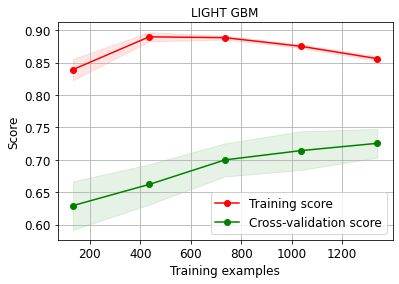

In [42]:
CVS=[]
R2=[]
MSE=[]
MAE=[]
RMSE=[]
NAME=[]
kf=KFold(n_splits=5,shuffle=True)
for name, model in models.items():
  font=pyfiglet.figlet_format(name)
  print(font)
  NAME.append(name)
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  mse=mean_squared_error(y_test,y_pred)
  MSE.append(mse)
  print("MEAN SQUARED ERROR",mse)
  mae=mean_absolute_error(y_test,y_pred)
  MAE.append(mae)
  print('\n')
  print("MEAN ABSOLUTE ERROR",mae)
  cvs=cross_val_score(model,X,np.log(y),scoring='r2',cv=kf).mean()
  CVS.append(cvs)
  print('\n')
  print("CVS_SCORE",cvs)
  r2=r2_score(y_test,y_pred)
  R2.append(r2)
  print('\n')
  print("R2_SCORE",r2)
  rmse=np.sqrt(mse)
  RMSE.append(rmse)
  print('\n')
  print("RMSE",rmse)
  print('\n')
  print('MODEL PERFORMANCE CURVE')
  skplt.estimators.plot_learning_curve(model,X,np.log(y),cv=kf,scoring='r2',title=name,text_fontsize='large')
  plt.show()

In [43]:
models_result=pd.DataFrame({
    "NAME":NAME,
    "Cross_Val_Score":CVS,
    "R2_score":R2,
    "Mean_squared_error":MSE,
    "Mean_Absolute_Error":MAE,
    "RMSE":RMSE
})

In [44]:
models_result

,NAME,Cross_Val_Score,R2_score,Mean_squared_error,Mean_Absolute_Error,RMSE
0,XGB Regressor,0.719294,0.728982,0.068080,0.197141,0.260922
1,ExtraTrees Regressor,0.692417,0.686074,0.078859,0.184097,0.280818
2,RandomForest Regressor,0.714508,0.738310,0.065737,0.178241,0.256392
3,Linear Regression,0.445100,0.422638,0.145034,0.310727,0.380834
4,DecisionTree Regressor,0.637543,0.604147,0.099439,0.206853,0.315340
5,Lasso,-0.006819,-0.003943,0.252192,0.421478,0.502187
6,LIGHT GBM,0.721296,0.730077,0.067805,0.185964,0.260394


**I will do hyperparameter Tuning of XGB because it is giving me good CVS and 72% R2 SCore**

In [45]:
XGB=XGBRegressor()

In [57]:
XGB.fit(X_train,y_train)

[07:53:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [58]:
XGB.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

#Hyperparameter Tuning

In [59]:
params={
    'booster':['gbtree','dart'],
    'importance_type':['gain','split'],
    'max_depth':[3,4,6,5,7],
    'n_estimators':[100,200,500]
}

In [60]:
Grid=GridSearchCV(estimator=XGB,param_grid=params,cv=kf,n_jobs=-1,scoring='r2')
Grid.fit(X,np.log(y))

[08:01:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objecti...ear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'booster': ['gbtree', 'dart'],
                        

In [61]:
Grid.best_params_

{'booster': 'gbtree',
 'importance_type': 'gain',
 'max_depth': 3,
 'n_estimators': 200}

In [62]:
Grid.best_score_

0.7242999936925213

In [63]:
XGBR=XGBRegressor(booster= 'dart',
 importance_type= 'gain',
 max_depth= 7,
 n_estimators= 200)

In [64]:
XGBR.fit(X_train,y_train)

[08:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

#Final Model Learning Curve

MODEL PERFORMANCE CURVE
[08:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now d

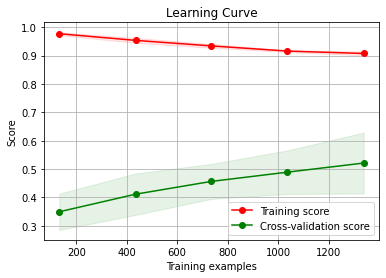

In [65]:
print('MODEL PERFORMANCE CURVE')
skplt.estimators.plot_learning_curve(XGBR,X,y,cv=kf,scoring='r2')
plt.show()

In [66]:
y_pred=XGBR.predict(X_test)

#Final model metrics

In [67]:
print("MSE",mean_squared_error(y_test,y_pred))
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2_Score",r2_score(y_test,y_pred))
print("Model_Score",XGBR.score(X_test,y_test))

MSE 0.07709220033828038
MAE 0.18841994317585678
RMSE 0.2776548222852979
R2_Score 0.6931065678402668
Model_Score 0.6931065678402668


In [68]:
import joblib
joblib.dump(Grid,"Flight.obj")

['Flight.obj']

In [69]:
model=joblib.load('/content/Flight.obj')

[08:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:02:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [71]:
np.exp(model.predict(X_test))

array([13717.246 , 10785.277 ,  3294.0044,  6942.6113,  4337.868 ,
       11270.078 , 11757.837 ,  4074.5757, 11791.401 , 11459.647 ,
       12979.477 , 11046.847 ,  3192.5732,  4766.3203,  9599.644 ,
       13065.592 , 11046.847 ,  7193.847 ,  6128.7383, 11309.268 ,
       13562.893 ,  4644.7236, 10864.345 , 11142.209 ,  4983.489 ,
        9124.045 ,  4311.5757,  3715.3076, 10323.942 ,  8595.42  ,
        3947.358 , 10732.938 , 10496.195 ,  5234.26  , 13240.171 ,
        4983.489 , 10763.043 ,  5203.5654, 10612.368 , 11734.784 ,
        9432.455 ,  7289.5874,  5800.5195,  6575.044 ,  6382.812 ,
        4931.4976, 12133.976 , 13489.507 , 12144.163 , 12172.292 ,
       11415.254 , 10028.567 ,  2993.2957,  4231.7153, 11080.959 ,
        7405.7583,  2932.8508,  5963.852 , 14759.943 , 11178.481 ,
       14617.258 , 14312.705 ,  4530.3965, 11682.214 ,  9729.461 ,
       13562.893 , 12639.909 ,  4010.3076, 10759.903 ,  9597.3   ,
        4811.5796, 13210.819 ,  9333.212 , 11998.125 ,  6589.4

#Conclusion

1-Data was having only one continuous value that was our target column

2-I did EDA to understand the data and written the observation also

3-i did all the preprocessing from data cleaning to data transformation and also did Feature engineering

4-My all columns was categorical so there was no need to remove outliers and skewness and no need to apply scaling also

3-Finally i build a model that was giving me 90% CSV accuracy 

4-And finally my model can predict the flight price